<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Classical-Hyrid-Neural-Network-for-binary-image-classification-using-PyTorch-Qiskit-pipeline/blob/main/CPU_Changing_QCNN_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.1 MB 17.1 MB/s 
     |████████████████████████████████| 18.0 MB 127 kB/s 
     |████████████████████████████████| 234 kB 60.6 MB/s 
     |████████████████████████████████| 207 kB 60.4 MB/s 
     |████████████████████████████████| 2.1 MB 59.2 MB/s 
     |████████████████████████████████| 199 kB 62.0 MB/s 
     |████████████████████████████████| 1.4 MB 34.3 MB/s 
     |████████████████████████████████| 635 kB 47.0 MB/s 
     |████████████████████████████████| 68 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 33.9 MB 19 kB/s 
     |████████████████████████████████| 943 kB 22.1 MB/s 
     |████████████████████████████████| 3.2 MB 71.6 MB/s 
     |████████████████████████████████| 6.3 MB 46.9 MB/s 
  Created wheel for qiskit: filename=qiskit-0.28.0-py3-none-any.whl size=11090 sha256=e6e8f9bb217a7fc943ce1a36df9df6f1fa44c4fb5e4ee104a63d28e1ad863b03
  Stored in directory: /root/.cache/pip/wh

In [ ]:
# check if CUDA is available
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [3]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [6]:
class QuantumCircuit:
    
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [7]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [8]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


In [ ]:
len(cifar_trainset)

50000

In [9]:
from torch.utils.data import DataLoader, random_split

In [10]:
#cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

cifar_trainset, valid = random_split(cifar_trainset,[150,50])

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True)

In [11]:
@torch.no_grad()
def get_all_preds(model, test_loader):
    all_preds = torch.tensor([])
    for batch in test_loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

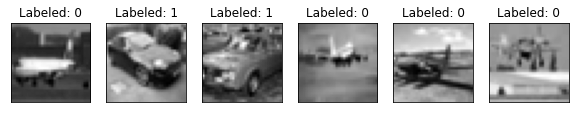

In [12]:
import numpy as np  
import matplotlib.pyplot as plt

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
  
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [13]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx] 
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

Files already downloaded and verified


Model one of the Hybrid Quantum Neural Network

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 1 	Training Loss: -0.508933 	Validation Loss: -0.750600
Epoch: 2 	Training Loss: -0.509933 	Validation Loss: -0.619800
Epoch: 3 	Training Loss: -0.545467 	Validation Loss: -0.667400
Epoch: 4 	Training Loss: -0.632600 	Validation Loss: -0.729600
Epoch: 5 	Training Loss: -0.695333 	Validation Loss: -0.751800
Epoch: 6 	Training Loss: -0.712667 	Validation Loss: -0.790200
Epoch: 7 	Training Loss: -0.720600 	Validation Loss: -0.855400
Epoch: 8 	Training Loss: -0.702200 	Validation Loss: -0.880600
Epoch: 9 	Training Loss: -0.742733 	Validation Loss: -0.902400
Epoch: 10 	Training Loss: -0.721200 	Validation Loss: -0.905200
Epoch: 11 	Training Loss: -0.751933 	Validation Loss: -0.912400
Epoch: 12 	Training Loss: -0.775067 	Validation Loss: -0.940400
Epoch: 13 	Training Loss: -0.785067 	Validation Loss: -0.950000
Epoch: 14 	Training Loss: -0.789733 	Validation Loss: -0.955000
Epoch: 15 	Training Loss: -0.806467 	Validation Loss: -0.982200
Epoch: 16 	Training Loss: -0.722133 	Validation L

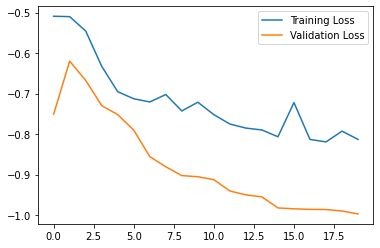

Performance on test data:
	Loss: -0.7354
	Accuracy: 78.0%


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.493333 	Validation Loss: -0.536000
Epoch: 2 	Training Loss: -0.434800 	Validation Loss: -0.523200
Epoch: 3 	Training Loss: -0.555400 	Validation Loss: -0.481000
Epoch: 4 	Training Loss: -0.460533 	Validation Loss: -0.389200
Epoch: 5 	Training Loss: -0.513467 	Validation Loss: -0.485800
Epoch: 6 	Training Loss: -0.508000 	Validation Loss: -0.492800
Epoch: 7 	Training Loss: -0.492800 	Validation Loss: -0.573400
Epoch: 8 	Training Loss: -0.520400 	Validation Loss: -0.552800
Epoch: 9 	Training Loss: -0.462733 	Validation Loss: -0.510600
Epoch: 10 	Training Loss: -0.478067 	Validation Loss: -0.564000
Epoch: 11 	Training Loss: -0.448067 	Validation Loss: -0.578800
Epoch: 12 	Training Loss: -0.567000 	Validation Loss: -0.498800
Epoch: 13 	Training Loss: -0.473000 	Validation Loss: -0.563200
Epoch: 14 	Training Loss: -0.471867 	Validation Loss: -0.546400
Epoch: 15 	Training Loss: -0.494333 	Validation Loss: -0.443600
Epoch: 16 	Training Loss: -0.498867 	Validation L

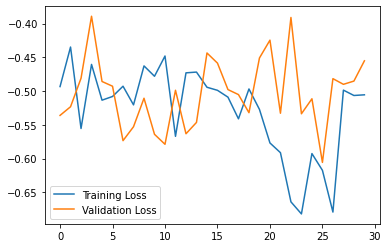

Performance on test data:
	Loss: -0.4562
	Accuracy: 46.5%


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: -0.488467 	Validation Loss: -0.623200
Epoch: 2 	Training Loss: -0.528933 	Validation Loss: -0.746200
Epoch: 3 	Training Loss: -0.517200 	Validation Loss: -0.731000
Epoch: 4 	Training Loss: -0.505533 	Validation Loss: -0.784600
Epoch: 5 	Training Loss: -0.551933 	Validation Loss: -0.797400
Epoch: 6 	Training Loss: -0.530467 	Validation Loss: -0.809000
Epoch: 7 	Training Loss: -0.567667 	Validation Loss: -0.818800
Epoch: 8 	Training Loss: -0.514533 	Validation Loss: -0.807800
Epoch: 9 	Training Loss: -0.504600 	Validation Loss: -0.846200
Epoch: 10 	Training Loss: -0.487400 	Validation Loss: -0.851400
Epoch: 11 	Training Loss: -0.509667 	Validation Loss: -0.865400
Epoch: 12 	Training Loss: -0.564867 	Validation Loss: -0.863800
Epoch: 13 	Training Loss: -0.569133 	Validation Loss: -0.887000
Epoch: 14 	Training Loss: -0.567467 	Validation Loss: -0.889000
Epoch: 15 	Training Loss: -0.564333 	Validation Loss: -0.882400
Epoch: 16 	Training Loss: -0.576133 	Validation L

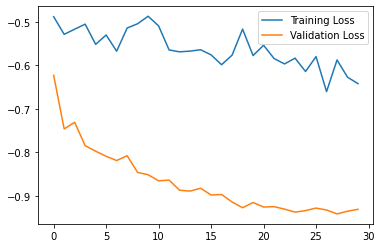

Performance on test data:
	Loss: -0.6899
	Accuracy: 73.5%


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.476667 	Validation Loss: -0.732600
Epoch: 2 	Training Loss: -0.527667 	Validation Loss: -0.818200
Epoch: 3 	Training Loss: -0.490600 	Validation Loss: -0.808200
Epoch: 4 	Training Loss: -0.549800 	Validation Loss: -0.872000
Epoch: 5 	Training Loss: -0.486333 	Validation Loss: -0.865200
Epoch: 6 	Training Loss: -0.551133 	Validation Loss: -0.902200
Epoch: 7 	Training Loss: -0.463667 	Validation Loss: -0.917600
Epoch: 8 	Training Loss: -0.521133 	Validation Loss: -0.938600
Epoch: 9 	Training Loss: -0.644333 	Validation Loss: -0.941200
Epoch: 10 	Training Loss: -0.686467 	Validation Loss: -0.947800
Epoch: 11 	Training Loss: -0.704867 	Validation Loss: -0.945400
Epoch: 12 	Training Loss: -0.699667 	Validation Loss: -0.965000
Epoch: 13 	Training Loss: -0.708333 	Validation Loss: -0.976800
Epoch: 14 	Training Loss: -0.728867 	Validation Loss: -0.977000
Epoch: 15 	Training Loss: -0.716400 	Validation Loss: -0.983400
Epoch: 16 	Training Loss: -0.738000 	Validation L

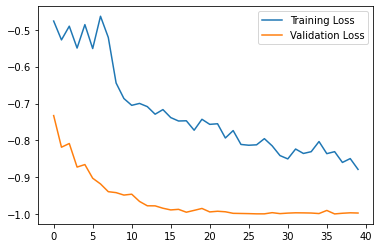

Performance on test data:
	Loss: -0.7266
	Accuracy: 74.5%


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 40
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 50
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.480067 	Validation Loss: -0.773400
Epoch: 2 	Training Loss: -0.482800 	Validation Loss: -0.809800
Epoch: 3 	Training Loss: -0.509600 	Validation Loss: -0.846200
Epoch: 4 	Training Loss: -0.521533 	Validation Loss: -0.858800
Epoch: 5 	Training Loss: -0.515667 	Validation Loss: -0.883800
Epoch: 6 	Training Loss: -0.512200 	Validation Loss: -0.887000
Epoch: 7 	Training Loss: -0.476533 	Validation Loss: -0.908200
Epoch: 8 	Training Loss: -0.513200 	Validation Loss: -0.919200
Epoch: 9 	Training Loss: -0.501467 	Validation Loss: -0.932400
Epoch: 10 	Training Loss: -0.518667 	Validation Loss: -0.928600
Epoch: 11 	Training Loss: -0.462267 	Validation Loss: -0.926800
Epoch: 12 	Training Loss: -0.530267 	Validation Loss: -0.928000
Epoch: 13 	Training Loss: -0.553400 	Validation Loss: -0.956600
Epoch: 14 	Training Loss: -0.638400 	Validation Loss: -0.969000
Epoch: 15 	Training Loss: -0.661067 	Validation Loss: -0.970400
Epoch: 16 	Training Loss: -0.680400 	Validation L

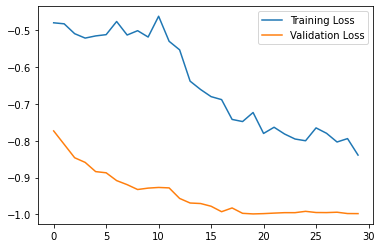

Performance on test data:
	Loss: -0.7898
	Accuracy: 83.0%


In [ ]:

###This is CPU run not GPU


%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

**Model 2 changing 500->20**

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2) #Added layer
        x = F.relu(self.conv2(x))
        x = self.dropout(x) #Added layer
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

        

Epoch: 1 	Training Loss: -0.472733 	Validation Loss: -0.518200
Epoch: 2 	Training Loss: -0.525933 	Validation Loss: -0.500200
Epoch: 3 	Training Loss: -0.493267 	Validation Loss: -0.366200
Epoch: 4 	Training Loss: -0.528733 	Validation Loss: -0.545800
Epoch: 5 	Training Loss: -0.497733 	Validation Loss: -0.417600
Validation loss decreased (inf --> -0.480000).  Saving model ...


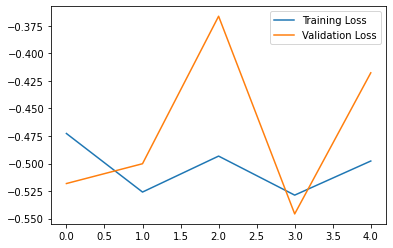

Performance on test data:
	Loss: -0.4864
	Accuracy: 50.0%


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.485333 	Validation Loss: -0.497000
Epoch: 2 	Training Loss: -0.494800 	Validation Loss: -0.531000
Epoch: 3 	Training Loss: -0.487467 	Validation Loss: -0.557000
Epoch: 4 	Training Loss: -0.528133 	Validation Loss: -0.472800
Epoch: 5 	Training Loss: -0.467867 	Validation Loss: -0.501800
Epoch: 6 	Training Loss: -0.504533 	Validation Loss: -0.558400
Epoch: 7 	Training Loss: -0.517267 	Validation Loss: -0.483200
Epoch: 8 	Training Loss: -0.530800 	Validation Loss: -0.445400
Epoch: 9 	Training Loss: -0.509200 	Validation Loss: -0.562800
Epoch: 10 	Training Loss: -0.513000 	Validation Loss: -0.511000
Epoch: 11 	Training Loss: -0.537000 	Validation Loss: -0.545000
Epoch: 12 	Training Loss: -0.484600 	Validation Loss: -0.476400
Epoch: 13 	Training Loss: -0.492067 	Validation Loss: -0.486800
Epoch: 14 	Training Loss: -0.488533 	Validation Loss: -0.504200
Epoch: 15 	Training Loss: -0.448133 	Validation Loss: -0.436200
Epoch: 16 	Training Loss: -0.476333 	Validation L

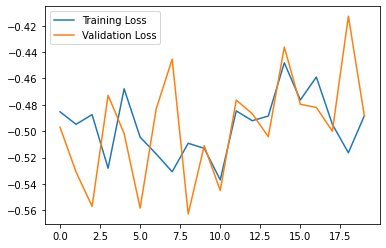

Performance on test data:
	Loss: -0.5430
	Accuracy: 54.5%


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.483600 	Validation Loss: -0.397800
Epoch: 2 	Training Loss: -0.503333 	Validation Loss: -0.501400
Epoch: 3 	Training Loss: -0.543467 	Validation Loss: -0.652000
Epoch: 4 	Training Loss: -0.583000 	Validation Loss: -0.417800
Epoch: 5 	Training Loss: -0.601667 	Validation Loss: -0.660800
Epoch: 6 	Training Loss: -0.600867 	Validation Loss: -0.397800
Epoch: 7 	Training Loss: -0.644533 	Validation Loss: -0.515000
Epoch: 8 	Training Loss: -0.646333 	Validation Loss: -0.472800
Epoch: 9 	Training Loss: -0.635733 	Validation Loss: -0.508600
Epoch: 10 	Training Loss: -0.676200 	Validation Loss: -0.488000
Epoch: 11 	Training Loss: -0.586000 	Validation Loss: -0.450800
Epoch: 12 	Training Loss: -0.482867 	Validation Loss: -0.555800
Epoch: 13 	Training Loss: -0.505867 	Validation Loss: -0.475600
Epoch: 14 	Training Loss: -0.461733 	Validation Loss: -0.539000
Epoch: 15 	Training Loss: -0.503200 	Validation Loss: -0.442000
Epoch: 16 	Training Loss: -0.462667 	Validation L

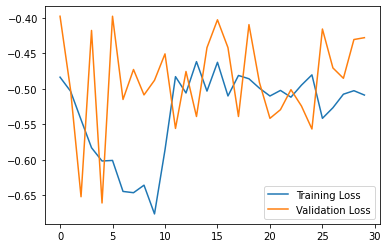

Performance on test data:
	Loss: -0.4682
	Accuracy: 46.0%


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 40
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Model 3

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)   #Added layer
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)



   

Epoch: 1 	Training Loss: -0.492933 	Validation Loss: -0.495600
Epoch: 2 	Training Loss: -0.509467 	Validation Loss: -0.496800
Epoch: 3 	Training Loss: -0.490400 	Validation Loss: -0.441800
Epoch: 4 	Training Loss: -0.517467 	Validation Loss: -0.432200
Epoch: 5 	Training Loss: -0.491600 	Validation Loss: -0.437200


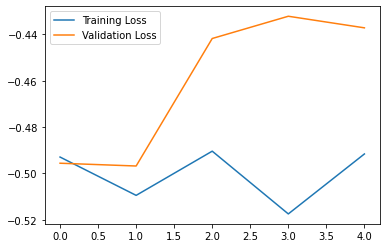

Performance on test data:
	Loss: -0.4494
	Accuracy: 45.0%


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.505933 	Validation Loss: -0.671600
Epoch: 2 	Training Loss: -0.515200 	Validation Loss: -0.727200
Epoch: 3 	Training Loss: -0.499467 	Validation Loss: -0.788200
Epoch: 4 	Training Loss: -0.539333 	Validation Loss: -0.826400
Epoch: 5 	Training Loss: -0.547867 	Validation Loss: -0.862400
Epoch: 6 	Training Loss: -0.651800 	Validation Loss: -0.870600
Epoch: 7 	Training Loss: -0.670333 	Validation Loss: -0.886800
Epoch: 8 	Training Loss: -0.643000 	Validation Loss: -0.892400
Epoch: 9 	Training Loss: -0.671667 	Validation Loss: -0.908200
Epoch: 10 	Training Loss: -0.712467 	Validation Loss: -0.916000
Epoch: 11 	Training Loss: -0.690667 	Validation Loss: -0.934800
Epoch: 12 	Training Loss: -0.722667 	Validation Loss: -0.940800
Epoch: 13 	Training Loss: -0.736133 	Validation Loss: -0.946400
Epoch: 14 	Training Loss: -0.724333 	Validation Loss: -0.952200
Epoch: 15 	Training Loss: -0.747933 	Validation Loss: -0.954800
Epoch: 16 	Training Loss: -0.689133 	Validation L

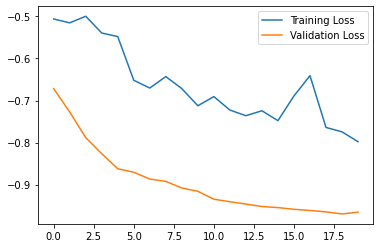

Performance on test data:
	Loss: -0.7172
	Accuracy: 72.0%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.506667 	Validation Loss: -0.541200
Epoch: 2 	Training Loss: -0.536333 	Validation Loss: -0.595600
Epoch: 3 	Training Loss: -0.500600 	Validation Loss: -0.491600
Epoch: 4 	Training Loss: -0.515667 	Validation Loss: -0.469600
Epoch: 5 	Training Loss: -0.504333 	Validation Loss: -0.539600
Epoch: 6 	Training Loss: -0.528533 	Validation Loss: -0.543000
Epoch: 7 	Training Loss: -0.523200 	Validation Loss: -0.563000
Epoch: 8 	Training Loss: -0.541600 	Validation Loss: -0.465000
Epoch: 9 	Training Loss: -0.575200 	Validation Loss: -0.524600
Epoch: 10 	Training Loss: -0.572733 	Validation Loss: -0.515200
Epoch: 11 	Training Loss: -0.561867 	Validation Loss: -0.594000
Epoch: 12 	Training Loss: -0.456533 	Validation Loss: -0.449000
Epoch: 13 	Training Loss: -0.485133 	Validation Loss: -0.551800
Epoch: 14 	Training Loss: -0.499867 	Validation Loss: -0.534800
Epoch: 15 	Training Loss: -0.471333 	Validation Loss: -0.594400
Epoch: 16 	Training Loss: -0.517333 	Validation L

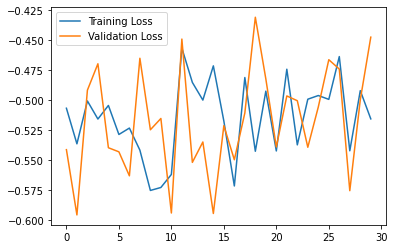

Performance on test data:
	Loss: -0.5235
	Accuracy: 53.0%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.502133 	Validation Loss: -0.636400
Epoch: 2 	Training Loss: -0.488933 	Validation Loss: -0.742600
Epoch: 3 	Training Loss: -0.495067 	Validation Loss: -0.766200
Epoch: 4 	Training Loss: -0.498067 	Validation Loss: -0.782600
Epoch: 5 	Training Loss: -0.484600 	Validation Loss: -0.778000
Epoch: 6 	Training Loss: -0.481067 	Validation Loss: -0.809000
Epoch: 7 	Training Loss: -0.478267 	Validation Loss: -0.809000
Epoch: 8 	Training Loss: -0.500733 	Validation Loss: -0.829200
Epoch: 9 	Training Loss: -0.499067 	Validation Loss: -0.845800
Epoch: 10 	Training Loss: -0.496067 	Validation Loss: -0.860400
Epoch: 11 	Training Loss: -0.510800 	Validation Loss: -0.864400
Epoch: 12 	Training Loss: -0.499467 	Validation Loss: -0.875600
Epoch: 13 	Training Loss: -0.524200 	Validation Loss: -0.891000
Epoch: 14 	Training Loss: -0.571267 	Validation Loss: -0.890400
Epoch: 15 	Training Loss: -0.590467 	Validation Loss: -0.900200
Epoch: 16 	Training Loss: -0.563600 	Validation L

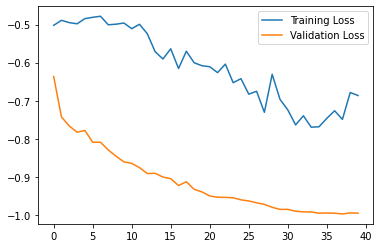

Performance on test data:
	Loss: -0.7503
	Accuracy: 76.0%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 40
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

**Model 4** - better accuracy rate

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d() 
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        #x = self.dropout(x) omitting this layer
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 1 	Training Loss: -0.507867 	Validation Loss: -0.703200
Epoch: 2 	Training Loss: -0.525333 	Validation Loss: -0.795200
Epoch: 3 	Training Loss: -0.593067 	Validation Loss: -0.805600
Epoch: 4 	Training Loss: -0.664267 	Validation Loss: -0.825800
Epoch: 5 	Training Loss: -0.702800 	Validation Loss: -0.894400
Epoch: 6 	Training Loss: -0.744667 	Validation Loss: -0.926600
Epoch: 7 	Training Loss: -0.763400 	Validation Loss: -0.918800
Epoch: 8 	Training Loss: -0.765600 	Validation Loss: -0.946000
Epoch: 9 	Training Loss: -0.802600 	Validation Loss: -0.970600
Epoch: 10 	Training Loss: -0.813200 	Validation Loss: -0.980000
Epoch: 11 	Training Loss: -0.830333 	Validation Loss: -0.977600
Epoch: 12 	Training Loss: -0.825267 	Validation Loss: -0.985000
Epoch: 13 	Training Loss: -0.851000 	Validation Loss: -0.989200
Epoch: 14 	Training Loss: -0.855800 	Validation Loss: -0.990400
Epoch: 15 	Training Loss: -0.879267 	Validation Loss: -0.992200
Epoch: 16 	Training Loss: -0.901800 	Validation L

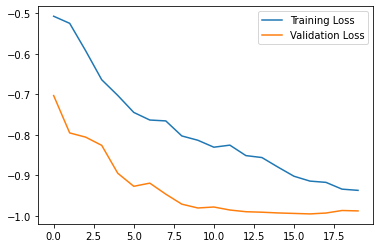

Performance on test data:
	Loss: -0.7324
	Accuracy: 80.5%


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.478067 	Validation Loss: -0.678400
Epoch: 2 	Training Loss: -0.545933 	Validation Loss: -0.686000
Epoch: 3 	Training Loss: -0.529133 	Validation Loss: -0.688400
Epoch: 4 	Training Loss: -0.633267 	Validation Loss: -0.785800
Epoch: 5 	Training Loss: -0.711933 	Validation Loss: -0.782800
Epoch: 6 	Training Loss: -0.773133 	Validation Loss: -0.847200
Epoch: 7 	Training Loss: -0.792067 	Validation Loss: -0.905400
Epoch: 8 	Training Loss: -0.779733 	Validation Loss: -0.928200
Epoch: 9 	Training Loss: -0.807267 	Validation Loss: -0.949200
Epoch: 10 	Training Loss: -0.828400 	Validation Loss: -0.954400
Epoch: 11 	Training Loss: -0.834067 	Validation Loss: -0.965400
Epoch: 12 	Training Loss: -0.833733 	Validation Loss: -0.981400
Epoch: 13 	Training Loss: -0.852133 	Validation Loss: -0.978400
Epoch: 14 	Training Loss: -0.861067 	Validation Loss: -0.987400
Epoch: 15 	Training Loss: -0.885267 	Validation Loss: -0.981400
Epoch: 16 	Training Loss: -0.889000 	Validation L

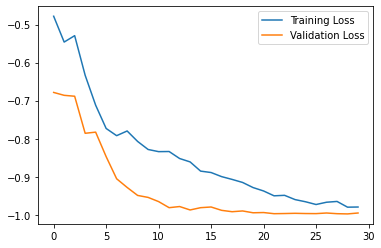

Performance on test data:
	Loss: -0.7363
	Accuracy: 78.0%


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.510333 	Validation Loss: -0.412000
Epoch: 2 	Training Loss: -0.608667 	Validation Loss: -0.502400
Epoch: 3 	Training Loss: -0.470600 	Validation Loss: -0.464000
Epoch: 4 	Training Loss: -0.533467 	Validation Loss: -0.465600
Epoch: 5 	Training Loss: -0.455467 	Validation Loss: -0.415600
Epoch: 6 	Training Loss: -0.484533 	Validation Loss: -0.553600
Epoch: 7 	Training Loss: -0.533400 	Validation Loss: -0.565800
Epoch: 8 	Training Loss: -0.513533 	Validation Loss: -0.497400
Epoch: 9 	Training Loss: -0.490467 	Validation Loss: -0.579200
Epoch: 10 	Training Loss: -0.492200 	Validation Loss: -0.512600
Epoch: 11 	Training Loss: -0.477133 	Validation Loss: -0.603600
Epoch: 12 	Training Loss: -0.477200 	Validation Loss: -0.410800
Epoch: 13 	Training Loss: -0.542867 	Validation Loss: -0.419000
Epoch: 14 	Training Loss: -0.537733 	Validation Loss: -0.440600
Epoch: 15 	Training Loss: -0.486267 	Validation Loss: -0.531600
Epoch: 16 	Training Loss: -0.470800 	Validation L

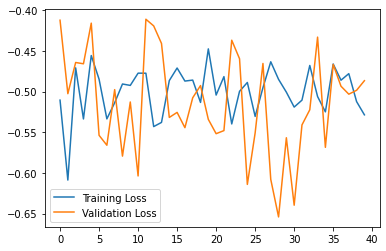

Performance on test data:
	Loss: -0.5200
	Accuracy: 52.0%


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 40
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.485333 	Validation Loss: -0.682400
Epoch: 2 	Training Loss: -0.634133 	Validation Loss: -0.820200
Epoch: 3 	Training Loss: -0.737267 	Validation Loss: -0.856600
Epoch: 4 	Training Loss: -0.780333 	Validation Loss: -0.894000
Epoch: 5 	Training Loss: -0.786400 	Validation Loss: -0.883200
Epoch: 6 	Training Loss: -0.788533 	Validation Loss: -0.925400
Epoch: 7 	Training Loss: -0.810667 	Validation Loss: -0.962200
Epoch: 8 	Training Loss: -0.791200 	Validation Loss: -0.979400
Epoch: 9 	Training Loss: -0.813000 	Validation Loss: -0.981800
Epoch: 10 	Training Loss: -0.837600 	Validation Loss: -0.997200
Epoch: 11 	Training Loss: -0.843800 	Validation Loss: -0.995400
Epoch: 12 	Training Loss: -0.884133 	Validation Loss: -0.997800
Epoch: 13 	Training Loss: -0.900400 	Validation Loss: -0.996600
Epoch: 14 	Training Loss: -0.889400 	Validation Loss: -0.994800
Epoch: 15 	Training Loss: -0.931333 	Validation Loss: -0.996200
Epoch: 16 	Training Loss: -0.943267 	Validation L

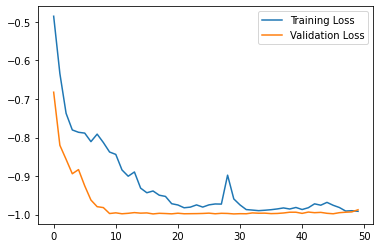

Performance on test data:
	Loss: -0.7701
	Accuracy: 82.0%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 50
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.541400 	Validation Loss: -0.736000
Epoch: 2 	Training Loss: -0.690600 	Validation Loss: -0.803200
Epoch: 3 	Training Loss: -0.754667 	Validation Loss: -0.867800
Epoch: 4 	Training Loss: -0.776333 	Validation Loss: -0.907200
Epoch: 5 	Training Loss: -0.784400 	Validation Loss: -0.924200
Epoch: 6 	Training Loss: -0.822000 	Validation Loss: -0.944000
Epoch: 7 	Training Loss: -0.842000 	Validation Loss: -0.961000
Epoch: 8 	Training Loss: -0.864533 	Validation Loss: -0.970000
Epoch: 9 	Training Loss: -0.881867 	Validation Loss: -0.991400
Epoch: 10 	Training Loss: -0.892867 	Validation Loss: -0.989000
Epoch: 11 	Training Loss: -0.916533 	Validation Loss: -0.990000
Epoch: 12 	Training Loss: -0.926467 	Validation Loss: -0.995400
Epoch: 13 	Training Loss: -0.942467 	Validation Loss: -0.996800
Epoch: 14 	Training Loss: -0.944200 	Validation Loss: -0.997000
Epoch: 15 	Training Loss: -0.951933 	Validation Loss: -0.996600
Epoch: 16 	Training Loss: -0.961867 	Validation L

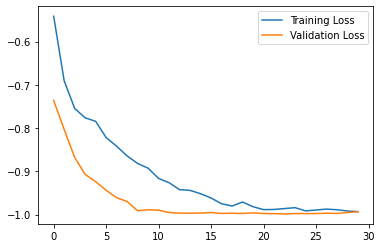

Performance on test data:
	Loss: -0.7578
	Accuracy: 80.5%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: 0.748926 	Validation Loss: 0.509182
Epoch: 2 	Training Loss: 0.753013 	Validation Loss: 0.435813
Epoch: 3 	Training Loss: 0.772438 	Validation Loss: 0.438703
Epoch: 4 	Training Loss: 0.730939 	Validation Loss: 0.424599
Epoch: 5 	Training Loss: 0.727822 	Validation Loss: 0.417728
Epoch: 6 	Training Loss: 0.722171 	Validation Loss: 0.413736
Epoch: 7 	Training Loss: 0.652582 	Validation Loss: 0.375665
Epoch: 8 	Training Loss: 0.647695 	Validation Loss: 0.376211
Epoch: 9 	Training Loss: 0.563613 	Validation Loss: 0.357747
Epoch: 10 	Training Loss: 0.555788 	Validation Loss: 0.361409
Epoch: 11 	Training Loss: 0.554909 	Validation Loss: 0.360107
Epoch: 12 	Training Loss: 0.516059 	Validation Loss: 0.356147
Epoch: 13 	Training Loss: 0.487939 	Validation Loss: 0.347875
Epoch: 14 	Training Loss: 0.504114 	Validation Loss: 0.343565
Epoch: 15 	Training Loss: 0.479273 	Validation Loss: 0.343249
Epoch: 16 	Training Loss: 0.489235 	Validation Loss: 0.338558
Epoch: 17 	Traini

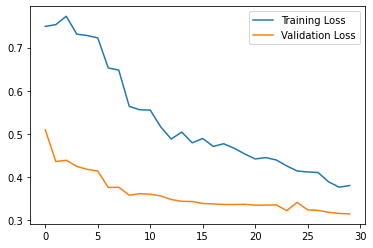

Performance on test data:
	Loss: 0.5191
	Accuracy: 78.0%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.CrossEntropyLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.502267 	Validation Loss: -0.754000
Epoch: 2 	Training Loss: -0.528133 	Validation Loss: -0.808600
Epoch: 3 	Training Loss: -0.659200 	Validation Loss: -0.848000
Epoch: 4 	Training Loss: -0.756733 	Validation Loss: -0.853800
Epoch: 5 	Training Loss: -0.769067 	Validation Loss: -0.885200
Epoch: 6 	Training Loss: -0.792267 	Validation Loss: -0.897400
Epoch: 7 	Training Loss: -0.790667 	Validation Loss: -0.907400
Epoch: 8 	Training Loss: -0.804733 	Validation Loss: -0.907400
Epoch: 9 	Training Loss: -0.803667 	Validation Loss: -0.929200
Epoch: 10 	Training Loss: -0.819867 	Validation Loss: -0.930600
Epoch: 11 	Training Loss: -0.820800 	Validation Loss: -0.933600
Epoch: 12 	Training Loss: -0.816200 	Validation Loss: -0.940800
Epoch: 13 	Training Loss: -0.835733 	Validation Loss: -0.948200
Epoch: 14 	Training Loss: -0.843867 	Validation Loss: -0.953600
Epoch: 15 	Training Loss: -0.842133 	Validation Loss: -0.956000
Epoch: 16 	Training Loss: -0.845333 	Validation L

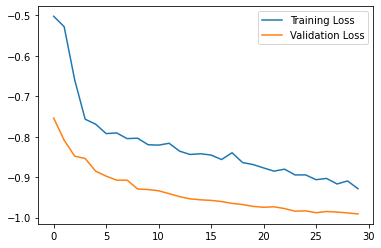

Performance on test data:
	Loss: -0.7630
	Accuracy: 79.5%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )